## ARGO Labs
### Sierra SWE Prediction Model Testing

Comments:

Two Models are Tested and Calibrated: 

1) XGBoost (XGB):
    
    Uncalibrated: Test RMSE = 2.454164972965364, Training RMSE = 1.293246518352459
    
    Calibrated: Test RMSE =  2.071810883149162, Training RMSE = 0.5296882625584641

In [319]:
#processing libraries:

import pandas as pd
import numpy as np
import os
import datetime
import pickle
from urllib.request import urlretrieve
import urllib.request as urllib
from sklearn.model_selection import GridSearchCV

#for XGB:

import xgboost as xgb

#testing:

from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

#visualization

import matplotlib.pyplot as plt
import seaborn as snb

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Baseline Data Pre-processing

In [328]:
def read_swe(url):
    '''function to read in and format the raw swe data (y data)'''
    
    swe_vol = pd.read_csv(url,header=None,names=['date','area','vol'])
    swe_vol['date'] = pd.to_datetime(swe_vol['date'])
    swe_vol.set_index('date',inplace=True)
    swe_vol.drop(columns=['area'],axis=1,inplace=True)
    
    return pd.DataFrame(swe_vol)

In [329]:
#read in y data
url = 'https://s3-us-west-2.amazonaws.com/cawater-public/swe/pred_SWE.txt'
swe_vol = read_swe(url)

In [330]:
def read_file(file_path):
    '''Function to read in daily x data'''
    if os.path.exists(os.getcwd()+'/'+file_path) == True:
        station = pd.read_csv(file_path)
    else:
        !unzip alldata.zip
        station = pd.read_csv(file_path)

    station['date'] = pd.to_datetime(station['date'])
    station = station.sort_values(by='date')
    station.set_index('date',inplace=True) #put date in the index
    station = station[station.index > '1984-09-29'] #removes days where there is no y-data
    station.replace('---','0',inplace=True)
    try:
        station.drop(columns=['Unnamed: 0'],axis=1,inplace=True) #drop non-station columns
    except:
        pass
    
    return station

In [331]:
#read in x data
file = 'fulldataset.csv'
station = read_file(file)

In [332]:
station.head()

,ADM,AGP,ALP,BCB,BCH,BFL,BGP,BIM,BKL,BLA,...,TUN,UBC,UTY,VLC,VRG,VVL,WC3,WHW,WTM,WWC
date,,,,,,,,,,,,,,,,,,,,,
1984-09-30,-0.012192,-0.012192,-0.012192,-0.012192,-0.012192,-0.012192,-0.012192,-0.012192,-0.012192,-0.042672,...,-0.012192,-0.012192,-0.012192,-0.012192,-0.012192,-0.012192,0.0,-0.012192,-0.012192,-0.012192
1984-10-01,0.005608,0.005608,0.027940,0.005608,0.005608,0.005608,0.005608,0.005608,0.005608,0.005608,...,0.005608,0.005608,0.005608,0.005608,0.005608,0.066040,0.0,0.005608,0.005608,0.000000
1984-10-02,0.027940,0.002946,0.022860,0.002116,0.001463,0.002946,0.002885,0.002198,0.002776,-0.042672,...,0.002338,0.002269,0.002790,0.002879,0.002838,0.066040,0.0,0.002934,0.002499,0.000000
1984-10-03,0.022860,0.001665,0.015240,0.001267,0.000900,0.001665,0.001658,0.001382,0.001972,-0.042672,...,0.001420,0.001372,0.001637,0.001657,0.001651,0.066040,0.0,0.001665,0.001559,0.000000
1984-10-04,0.015240,0.001773,0.012700,0.001635,0.001377,0.001773,0.001773,0.001734,0.000000,-0.039624,...,0.001737,0.001718,0.001772,0.001773,0.001773,0.066040,0.0,0.001773,0.001772,0.000000


In [333]:
#join the data sets
swe = pd.merge(left=swe_vol,right=station,left_index=True,right_index=True)
swe.shape

(12501, 137)

In [334]:
#for now, dropping columns where we only have NaNs - these are the weather stations that have no daily data
swe.dropna(axis=1, how='all',inplace=True)

In [335]:
X = swe.iloc[:,1:]
Y = swe.iloc[:,:1]

In [336]:
def create_lags(x, n_in=1, n_out=1, dropnan=True):
    """Frame a time series as a supervised learning dataset.Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning."""
    
    n_vars = 1 if type(x) is list else x.shape[1]
    df = pd.DataFrame(x)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    #y_lag = y.reset_index(inplace=True)
    #y_lag = y_lag.iloc[n_in:]
    #xy_lag = pd.merge(left=y_lag,right=agg,how='left',left_index=True,right_index=True)
    
    return agg

In [337]:
x_array = X.values
x_lag = create_lags(x_array,n_in=2,n_out=1)

In [338]:
Y.reset_index(inplace=True)

In [339]:
Y = Y.iloc[2:]

In [340]:
xy_lag = pd.merge(left=Y,right=x_lag,how='left',left_index=True,right_index=True)

In [341]:
xy_lag.head()

,date,vol,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),...,var127(t),var128(t),var129(t),var130(t),var131(t),var132(t),var133(t),var134(t),var135(t),var136(t)
2,1984-10-02,0.001481,-0.012192,-0.012192,-0.012192,-0.012192,-0.012192,-0.012192,-0.012192,-0.012192,...,0.002338,0.002269,0.002790,0.002879,0.002838,0.06604,0.0,0.002934,0.002499,0.0
3,1984-10-03,0.001043,0.005608,0.005608,0.027940,0.005608,0.005608,0.005608,0.005608,0.005608,...,0.001420,0.001372,0.001637,0.001657,0.001651,0.06604,0.0,0.001665,0.001559,0.0
4,1984-10-04,0.000779,0.027940,0.002946,0.022860,0.002116,0.001463,0.002946,0.002885,0.002198,...,0.001737,0.001718,0.001772,0.001773,0.001773,0.06604,0.0,0.001773,0.001772,0.0
5,1984-10-05,0.000611,0.022860,0.001665,0.015240,0.001267,0.000900,0.001665,0.001658,0.001382,...,0.001392,0.001361,0.001478,0.001479,0.001479,0.06604,0.0,0.001479,0.001472,0.0
6,1984-10-06,0.000501,0.015240,0.001773,0.012700,0.001635,0.001377,0.001773,0.001773,0.001734,...,0.001445,0.001250,0.002052,0.002152,0.002140,0.06604,0.0,0.002211,0.001712,0.0


In [342]:
xy_lag.set_index('date',inplace=True)

In [343]:
#split into three dataframes: train, test, and predict
train = xy_lag.iloc[:round(len(xy_lag) * 0.65)]
test = xy_lag.iloc[round(len(xy_lag) * 0.65):-125]
predict = xy_lag.iloc[-125:] #predct is last 125 rows where there is no Y-data

In [344]:
#drop rows with Y NaN in train and test data...there are some missing volume days that need to be dropped for the models to work
train.dropna(subset=['vol'],inplace=True) 
test.dropna(subset=['vol'],inplace=True) 

/nfshome/cb4102/.conda/envs/deeplearn/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/nfshome/cb4102/.conda/envs/deeplearn/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [345]:
#quick check on lengths and % after drops (approx, no new denominator calculated)
print("training sample size: {}".format(len(train)), " | training %: {}".format((len(train) / len(swe))*100))
print("testing sample size: {}".format(len(test)), " | test %: {}".format((len(test) / len(swe))*100))
print("prediction sample size: {}".format(len(predict)), " | prediction %: {}".format((len(predict) / len(swe))*100))

training sample size: 8107  | training %: 64.8508119350452
testing sample size: 4243  | test %: 33.94128469722422
prediction sample size: 125  | prediction %: 0.9999200063994881


In [346]:
#split into X and Y for each of train, test, and predict
Y_train = train['vol']
X_train = train.iloc[:,1:]

Y_test = test['vol']
X_test = test.iloc[:,1:]

Y_predict = predict['vol']
X_predict = predict.iloc[:,1:]

# XGBoost Regression

In [59]:
#initialize baseline xgboost regression
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree=0.8, learning_rate=0.1,
                max_depth=10, n_estimators=20,seed=13)

In [60]:
#fit the model
xg_reg.fit(X_train,Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=20,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=13, silent=True,
       subsample=1)

In [61]:
#generate predictions
train_preds = xg_reg.predict(X_train)
test_preds = xg_reg.predict(X_test)
predict_preds = xg_reg.predict(X_predict) #for plooting

In [62]:
rmse = np.sqrt(mean_squared_error(Y_test, test_preds))
print("RMSE of the test set: {}".format(rmse))

RMSE of the test set: 2.3016508466086147


In [63]:
rmse = np.sqrt(mean_squared_error(Y_train, train_preds))
print("RMSE of the train set: {}".format(rmse))

RMSE of the train set: 1.2750316839177391


In [64]:
#join back to dates for graphing

train_graph = pd.merge(left=pd.DataFrame(train.index),right=pd.DataFrame(train_preds),how='left',
                       left_index=True,right_index=True)

test_graph = pd.merge(left=pd.DataFrame(test.index),right=pd.DataFrame(test_preds),how='left',
                       left_index=True,right_index=True)

pred_graph = pd.merge(left=pd.DataFrame(predict.index),right=pd.DataFrame(predict_preds),how='left',
                       left_index=True,right_index=True)

train_graph.set_index('date',inplace=True)
test_graph.set_index('date',inplace=True)
pred_graph.set_index('date',inplace=True)

In [65]:
#convert training data to data frames for graphing
Y_train = pd.DataFrame(Y_train)
Y_test = pd.DataFrame(Y_test)

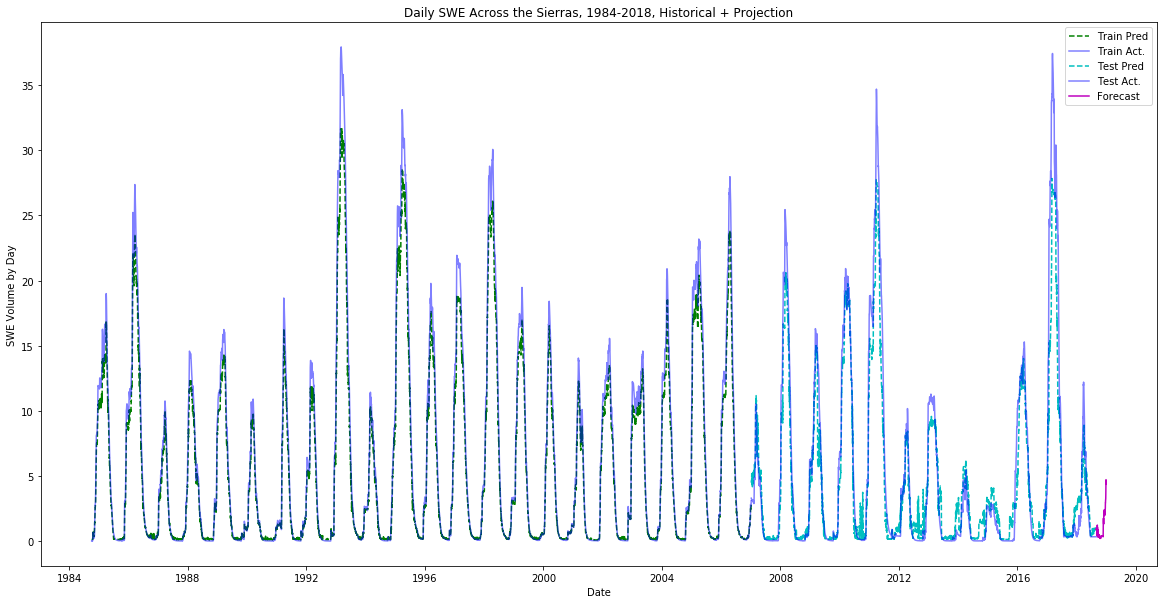

In [66]:
#quick plot to visualize data

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.plot(train_graph[0],color='g',linestyle='--',label='Train Pred')
ax.plot(Y_train['vol'],color='b',alpha=0.5,label='Train Act.')

ax.plot(test_graph[0],color='c',linestyle='--',label='Test Pred')
ax.plot(Y_test['vol'],color='b',alpha=0.5,label='Test Act.')

ax.plot(pred_graph[0],color='m',label='Forecast')

ax.set_xlabel("Date")
ax.set_ylabel("SWE Volume by Day")
ax.set_title("Daily SWE Across the Sierras, 1984-2018, Historical + Projection")
plt.legend()

Text(0.5, 1.0, 'Daily SWE Across the Sierras, 1984-2017, Actual vs. Predicted (Train set)')

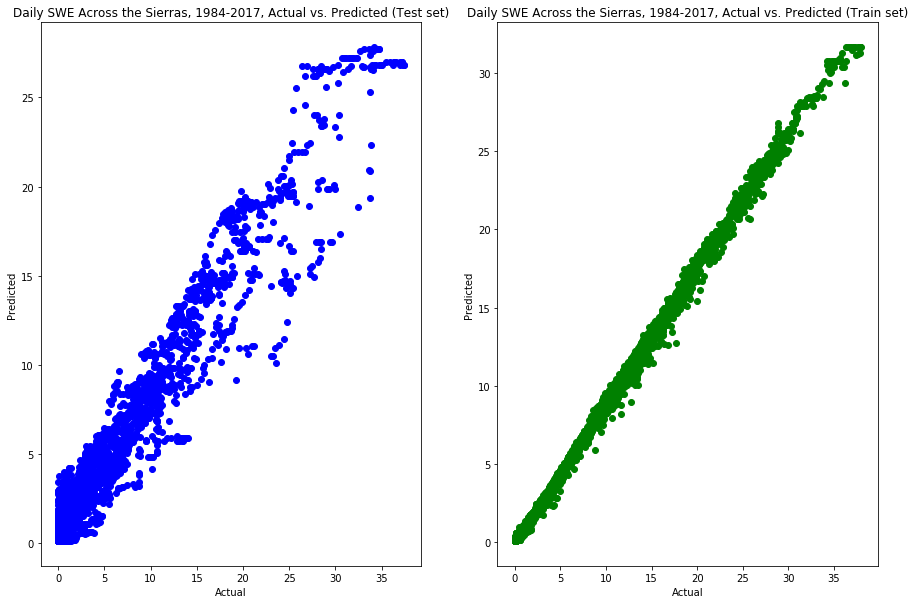

In [67]:
#scatter plot to show comparison of predicted vs actual on the training and test data sets

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(121)

ax.scatter(Y_test.values,test_preds,color='b')

ax1 = fig.add_subplot(122)

ax1.scatter(Y_train.values,train_preds,color='g')

ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.set_title("Daily SWE Across the Sierras, 1984-2017, Actual vs. Predicted (Test set)")

ax1.set_xlabel("Actual")
ax1.set_ylabel("Predicted")
ax1.set_title("Daily SWE Across the Sierras, 1984-2017, Actual vs. Predicted (Train set)")

#### Hyper parameter optimization

In [32]:
xg_reg.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 10,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 20,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 13,
 'silent': True,
 'subsample': 1}

In [165]:
#set up cross-validation 
xgtrain = xgb.DMatrix(data=X_train.values,label=Y_train.values) #set up training data in xgboost format

xgb_param = xg_reg.get_xgb_params() #get underlying parameters from baseline regression

#generate cross validation results to estimate the correct number of estimators at a specified learning rate 
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=400, nfold=5,
            metrics='rmse', early_stopping_rounds=50)

Text(0.5, 1.0, '# of Estimators Hyper-parameter Analysis')

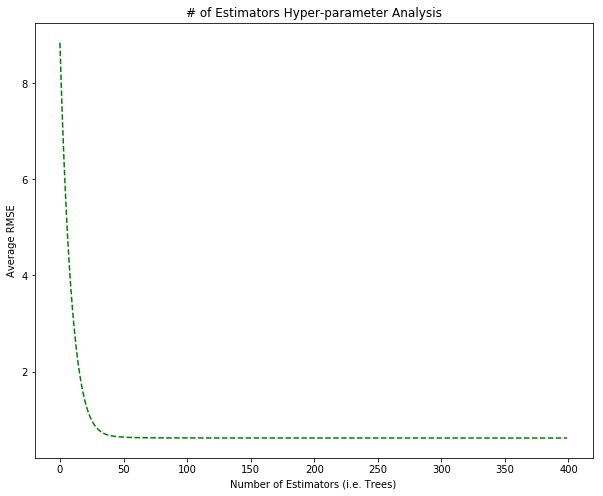

In [166]:
cvresult['test-rmse-mean']

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

ax.plot(cvresult['test-rmse-mean'],color='g',linestyle='--',label='Train Pred')

ax.set_xlabel("Number of Estimators (i.e. Trees)")
ax.set_ylabel("Average RMSE")
ax.set_title("# of Estimators Hyper-parameter Analysis")


#### Note: Setting n_estimators = 50 is optimal, no additional performance benefits for a larger number and runtime will increase

In [78]:
#set optimal n_estimators
xg_reg.set_params(n_estimators=150)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=5, learning_rate=0.03, max_delta_step=0,
       max_depth=6, min_child_weight=5, missing=None, n_estimators=150,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1.5, scale_pos_weight=1, seed=13,
       silent=True, subsample=1)

### Tune max_depth and min_child_weight

These parameters impact overfitting and need to be tuned

In [183]:
#set tests parameters for XGBoost Model
param_test1 = {
 'max_depth':range(3,10),
 'min_child_weight':range(1,6),
'learning_rate':[0.02,0.05,0.1],
'colsample_bytree':[0.3,0.5,0.8]}

#initialize grid search cross validation
gsearch1 = GridSearchCV(estimator=xg_reg, param_grid=param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train,Y_train) #fit data
gsearch1.best_params_, gsearch1.best_score_ #output results from best iteration

({'colsample_bytree': 0.3,
  'learning_rate': 0.05,
  'max_depth': 6,
  'min_child_weight': 5},
 -6.273017526937635)

In [81]:
#set optimal parameter based on tuning
xg_reg.set_params(max_depth=6)
xg_reg.set_params(min_child_weight=5)
xg_reg.set_params(learning_rate=0.05) #0.1 baseline
xg_reg.set_params(colsample_bytree=0.3) #0.8 baseline
xg_reg.set_params(gamma=5)
xg_reg.set_params(reg_alpha=0)
xg_reg.set_params(reg_lambda=1.5)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=5, learning_rate=0.05, max_delta_step=0,
       max_depth=6, min_child_weight=5, missing=None, n_estimators=150,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1.5, scale_pos_weight=1, seed=13,
       silent=True, subsample=1)

### Rerun model with tuned parameters

In [347]:
#fit the model
xg_reg.fit(X_train,Y_train)

#generate predictions
train_preds = xg_reg.predict(X_train)
test_preds = xg_reg.predict(X_test)
predict_preds = xg_reg.predict(X_predict) #for plooting

In [348]:
rmse1 = np.sqrt(mean_squared_error(Y_test, test_preds))
print("RMSE of the test set: {}".format(rmse1))

rmse2 = np.sqrt(mean_squared_error(Y_train, train_preds))
print("RMSE of the train set: {}".format(rmse2))

RMSE of the test set: 1.7759116987590293
RMSE of the train set: 0.3164797555079233


In [320]:
#save model results for pickling
pickle.dump(xg_reg, open("swe_xgb.pickle.dat", "wb"))

In [349]:
#join back to dates for graphing

train_graph = pd.merge(left=pd.DataFrame(train.index),right=pd.DataFrame(train_preds),how='left',
                       left_index=True,right_index=True)

test_graph = pd.merge(left=pd.DataFrame(test.index),right=pd.DataFrame(test_preds),how='left',
                       left_index=True,right_index=True)

pred_graph = pd.merge(left=pd.DataFrame(predict.index),right=pd.DataFrame(predict_preds),how='left',
                       left_index=True,right_index=True)

train_graph.set_index('date',inplace=True)
test_graph.set_index('date',inplace=True)
pred_graph.set_index('date',inplace=True)

#convert training data to data frames for graphing
Y_train = pd.DataFrame(Y_train)
Y_test = pd.DataFrame(Y_test)

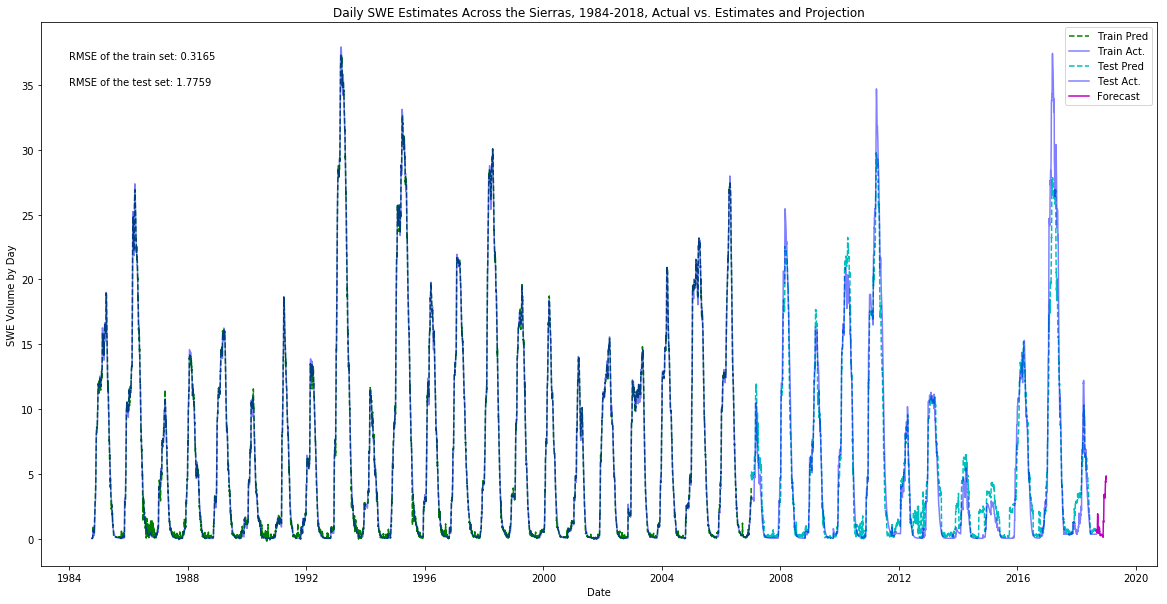

In [350]:
#quick plot to visualize data

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.plot(train_graph[0],color='g',linestyle='--',label='Train Pred')
ax.plot(Y_train['vol'],color='b',alpha=0.5,label='Train Act.')

ax.plot(test_graph[0],color='c',linestyle='--',label='Test Pred')
ax.plot(Y_test['vol'],color='b',alpha=0.5,label='Test Act.')

ax.plot(pred_graph[0],color='m',label='Forecast')

ax.set_xlabel("Date")
ax.set_ylabel("SWE Volume by Day")
ax.set_title("Daily SWE Estimates Across the Sierras, 1984-2018, Actual vs. Estimates and Projection")
plt.legend()

ax.text('1984-1-1', 37, "RMSE of the train set: {}".format(round(rmse2,4)))
ax.text('1984-1-1', 35, "RMSE of the test set: {}".format(round(rmse1,4)))

plt.savefig('SWE Time Series.png')

In [132]:
Y_test = pd.DataFrame(Y_test) #convert to df for correlation calc
Y_train = pd.DataFrame(Y_train) #convert to df for correlation calc

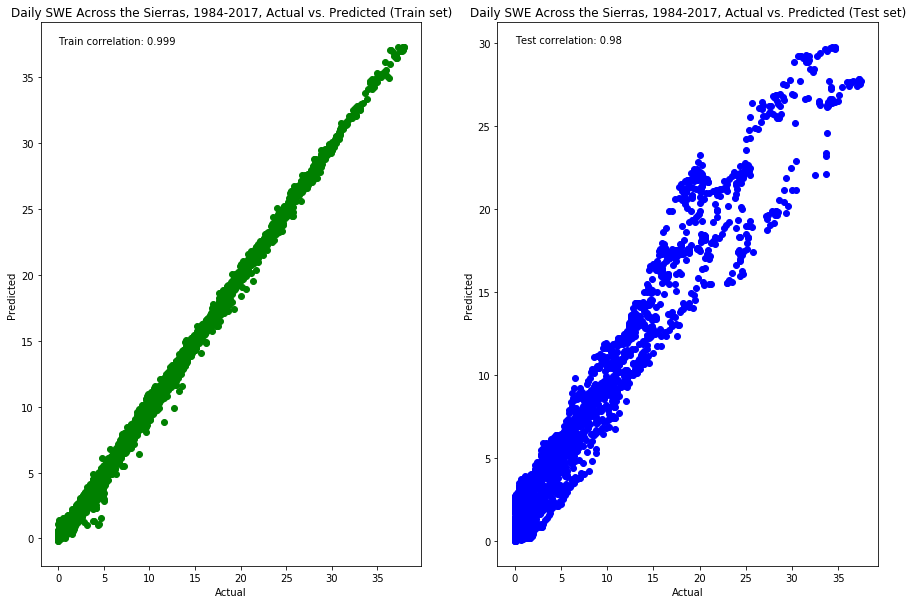

In [136]:
#scatter plot to show comparison of predicted vs actual on the training and test data sets

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(122)

ax.scatter(Y_test['vol'],test_graph[0],color='b')

ax1 = fig.add_subplot(121)

ax1.scatter(Y_train['vol'],train_graph[0],color='g')

ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.set_title("Daily SWE Across the Sierras, 1984-2017, Actual vs. Predicted (Test set)")

ax1.set_xlabel("Actual")
ax1.set_ylabel("Predicted")
ax1.set_title("Daily SWE Across the Sierras, 1984-2017, Actual vs. Predicted (Train set)")

ax.annotate("Test correlation: {}".format(round(Y_test['vol'].corr(test_graph[0]),2),xy=(1, 28), xytext=(0, 30))
ax1.annotate("Train correlation: {}".format(round(Y_train['vol'].corr(train_graph[0]),3),xy=(1, 28), xytext=(0, 37.5))

plt.savefig("SWE Correlation Plots.png")

In [184]:
#prep historical data for graphing
total_swe = pd.concat([Y_train,Y_test])

total_swe.reset_index(inplace=True)

#extract year and day of year from full date
total_swe['year'] = total_swe['date'].dt.year
total_swe['doy'] = total_swe['date'].dt.dayofyear

In [260]:
#set up select series for graph

avg_swe_series = total_swe[total_swe['date'] < '2017-10-01'].groupby('doy')['vol'].mean()
select_year_series = total_swe[(total_swe['date'] < '1991-10-01') & (total_swe['date'] > '1990-09-30')]

#format data frames

avg_swe_series = pd.DataFrame(avg_swe_series)
select_year_series = select_year_series[['doy','vol']]

avg_swe_series.reset_index(inplace=True)

#calculate water day from calendar day

avg_swe_series['water_day'] = [x-273 if x > 273 else x+92 for x in avg_swe_series['doy']]
select_year_series['water_day'] = [x-273 if x > 273 else x+92 for x in select_year_series['doy']]


avg_swe_series = avg_swe_series.iloc[:,1:]
select_year_series = select_year_series.iloc[:,1:]

actuals_series = pd.merge(select_year_series,avg_swe_series,how='left',left_on='water_day',right_on='water_day')

actuals_series['std_upper'] = actuals_series['vol_y'] + actuals_series['vol_y'].std()
actuals_series['std_lower'] =  actuals_series['vol_y'] - actuals_series['vol_y'].std()

In [305]:
#adjust the prediction data 

pred_graph.reset_index(inplace=True)

pred_series = pred_graph.iloc[-91:] #just takes dates for the beginning of the water year

#extract year and day of year from full date
pred_series['year'] = pred_series['date'].dt.year
pred_series['doy'] = pred_series['date'].dt.dayofyear

pred_series['water_day'] = [x-273 if x > 273 else x+92 for x in pred_series['doy']]

pred_series = pred_series[['water_day',0]]

/nfshome/cb4102/.conda/envs/deeplearn/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/nfshome/cb4102/.conda/envs/deeplearn/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/nfshome/cb4102/.conda/envs/deeplearn/lib/python3.5/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

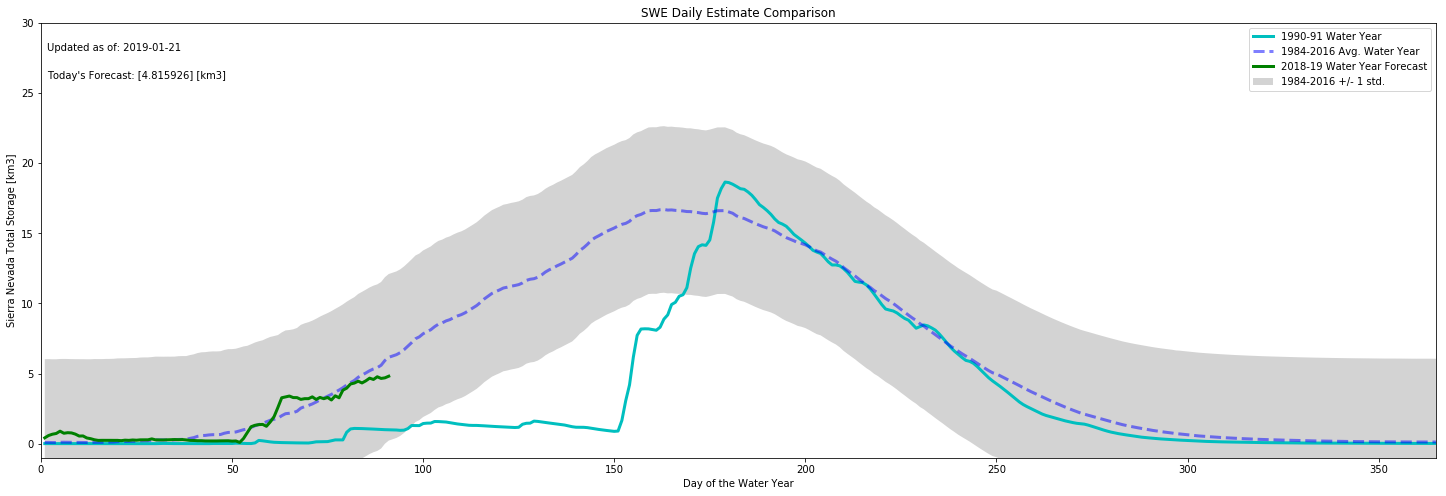

In [318]:
fig = plt.figure(figsize=(25,8))
ax = fig.add_subplot(111)

ax.plot(actuals_series['water_day'],actuals_series['vol_x'],color='c',label='1990-91 Water Year',linewidth=3)
ax.plot(actuals_series['water_day'],actuals_series['vol_y'],color='b',linestyle='--',alpha=0.5,label='1984-2016 Avg. Water Year',linewidth=3)
ax.plot(pred_series['water_day'],pred_series[0],color='g',label='2018-19 Water Year Forecast',linewidth=3)

ax.set_xlabel("Day of the Water Year")
ax.set_ylabel("Sierra Nevada Total Storage [km3]")
ax.set_title("SWE Daily Estimate Comparison")
ax.set_ylim(-1,30)
ax.set_xlim(0,365)

plt.fill_between(actuals_series['water_day'],actuals_series['std_lower'], actuals_series['std_upper'], facecolor='lightgray',label='1984-2016 +/- 1 std.')

plt.legend()

ax.annotate("Updated as of: {}".format(datetime.datetime.now().strftime("%Y-%m-%d")),xy=(1, 28), xytext=(1.5, 28))
ax.annotate("Today's Forecast: {} [km3]".format(pred_series[0].iloc[-1:].values),xy=(1, 28), xytext=(1.5, 26))

plt.savefig("Daily Water Year Graph.png")